# 3D ResNet50 (30 animal classes)

In [1]:
#%%python3 -m pip install --upgrade pip

In [2]:
%pip install mediapipe=='0.10.9'
%pip install opencv-python=='4.8.0.76'

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
import sys
sys.path.append("..")
from train_utils import VideoDataset, validate_model, train_model, display_frames, validate_model_batched
from models_resnet import resnet50

2024-02-25 17:48:34.607931: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-25 17:48:35.756295: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-25 17:48:39.016627: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import json

In [6]:
def save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic):
    with open(f'{save_path}/{model_name}_loss_acc_dynamic.json', 'w') as f:
        json.dump(
            {
                'train_loss_dynamic': train_loss_dynamic,
                'val_accuracy_dynamic': val_accuracy_dynamic
            },
            f)

In [7]:
use_cuda = True
seed = 1

train_batch_size = 1
test_batch_size = 1
val_batch_size = 1
IMG_SIZE = 112

limit_list = [] #["динозавр", "пингвин", "кролик"]

min_frame_count = 25

save = True

annotations_file = "/home/jupyter/mnt/s3/rsl-videos/slovo/slovo_annotations/SLOVO_DF_SHORT.tsv" # "/content/drive/MyDrive/slovo/SLOVO_DF_SHORT.tsv" #
dataloader_dir =  "/home/jupyter/mnt/s3/rsl-videos/slovo/Dataloaders/animals/" #"/content/drive/MyDrive/slovo/dataloaders/"

train_dataloader_name = 'color_frames_train_dataloader.pth'
val_dataloader_name = 'color_frames_val_dataloader.pth'

save_path = "/home/jupyter/mnt/s3/rsl-videos/slovo/models/animals/resnet50" #'/content/drive/MyDrive/slovo/models/ResNet50' #'/content/model'

In [8]:
video_labels = pd.read_csv(annotations_file, sep='\t')
video_labels['group_rank'] = video_labels.groupby(['text']).cumcount()+1;
video_labels['dataset'] = np.where(video_labels['group_rank']<17,'train', np.where(video_labels['group_rank']<19,'val', 'test'))
if len(limit_list)>0:
  video_labels = video_labels[video_labels.text.isin(limit_list)]
video_labels.tail(5)

,Unnamed: 0,attachment_id,text,begin,end,group_rank,dataset
595,55,25b5fb58-46dd-4fd6-9928-734460795b22,мышь,22,83,20,test
596,56,336e0e7a-ff68-427c-9a77-52626b81edd1,паук,42,74,19,test
597,57,d0ec4c00-6ff5-4089-ac9d-5a33a76fb037,паук,3,70,20,test
598,58,59ae408b-f87a-422a-bc57-2ff5af28ee57,бабочка,2,74,19,test
599,59,e421d77c-1dcd-4124-b2a4-b2415569a4dd,бабочка,63,131,20,test


In [9]:
classes = tuple(video_labels.text.unique())
n_class = len(classes)
print(f"Total number of classes: {n_class}. Example classes: {classes[:5]}")

Total number of classes: 30. Example classes: ('пингвин', 'жираф', 'лягушка', 'бегемот', 'козел')


In [10]:
train_dataloader = torch.load(dataloader_dir + train_dataloader_name)
print(f"Train dataloader contains: {len(train_dataloader)} videos")
val_dataloader = torch.load(dataloader_dir + val_dataloader_name)
print(f"Val dataloader contains: {len(val_dataloader)} videos")

Train dataloader contains: 480 videos
Val dataloader contains: 60 videos


In [11]:
use_cuda = use_cuda and torch.cuda.is_available()

if use_cuda:
  for dl in [train_dataloader, val_dataloader]:
    dl.num_workers = 0
    dl.pin_memory = True
  torch.cuda.manual_seed(seed)  # Set the random seed for the current GPU
else:
  torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

print(f"Device: {device}")

Device: cuda


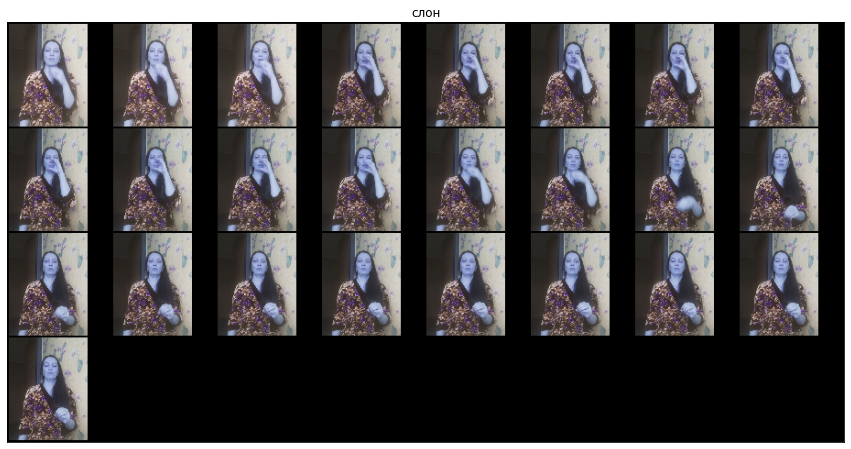

In [12]:
display_frames(n_frames=1, dataloader=train_dataloader, classes=classes)

In [13]:
frames, labels = next(iter(val_dataloader))
print(f"Frames shape: {frames.shape}") # (batch_size, -channels, frames, w, h) torch.Size([1, 3, 25, 112, 112])
print(f"Labels shape: {labels.shape}") # batch_size
print(f"Labels: {labels}") # class index

Frames shape: torch.Size([1, 3, 25, 112, 112])
Labels shape: torch.Size([1])
Labels: tensor([7])


In [14]:
bs = val_dataloader.batch_size

# ResNet 50, $lr = 10^{-3}$ bs=1

In [15]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.fc

Linear(in_features=2048, out_features=30, bias=True)

In [16]:
frames, labels = next(iter(val_dataloader))
frames = frames.to(device)
resnet.to(device)
print(f"Output shape: {resnet(frames/255).shape}") # batch size, number of classes

Output shape: torch.Size([1, 30])


In [17]:
lr_power = -3
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet50_animals_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [18]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=4.6651; val acc=0.033
Train Epoch 2/30: train_loss=3.5096; val acc=0.017
Train Epoch 3/30: train_loss=3.4857; val acc=0.033
Train Epoch 4/30: train_loss=3.4767; val acc=0.017
Train Epoch 5/30: train_loss=3.5114; val acc=0.033
Train Epoch 6/30: train_loss=3.4892; val acc=0.033
Train Epoch 7/30: train_loss=3.4905; val acc=0.000
Train Epoch 8/30: train_loss=3.4879; val acc=0.033
Train Epoch 9/30: train_loss=3.4712; val acc=0.033
Train Epoch 10/30: train_loss=3.4631; val acc=0.033
Train Epoch 11/30: train_loss=3.4778; val acc=0.033
Train Epoch 12/30: train_loss=3.4567; val acc=0.017
Train Epoch 13/30: train_loss=3.4514; val acc=0.017
Train Epoch 14/30: train_loss=3.4531; val acc=0.033
Train Epoch 15/30: train_loss=3.4454; val acc=0.033
Train Epoch 16/30: train_loss=3.4413; val acc=0.050
Train Epoch 17/30: train_loss=3.4348; val acc=0.017
Train Epoch 18/30: train_loss=3.4373; val acc=0.033
Train Epoch 19/30: train_loss=3.4273; val acc=0.033
Train Epoch 20/30: tr

# ResNet 50, $lr = 10^{-4}$ bs=1

In [19]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.fc

Linear(in_features=2048, out_features=30, bias=True)

In [20]:
lr_power = -4
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet50_animals_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [21]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=4.0057; val acc=0.033
Train Epoch 2/30: train_loss=3.7721; val acc=0.050
Train Epoch 3/30: train_loss=3.7622; val acc=0.033
Train Epoch 4/30: train_loss=3.7095; val acc=0.033
Train Epoch 5/30: train_loss=3.7012; val acc=0.033
Train Epoch 6/30: train_loss=3.6877; val acc=0.033
Train Epoch 7/30: train_loss=3.6631; val acc=0.050
Train Epoch 8/30: train_loss=3.6425; val acc=0.033
Train Epoch 9/30: train_loss=3.6255; val acc=0.033
Train Epoch 10/30: train_loss=3.5956; val acc=0.033
Train Epoch 11/30: train_loss=3.5659; val acc=0.033
Train Epoch 12/30: train_loss=3.5586; val acc=0.050
Train Epoch 13/30: train_loss=3.614; val acc=0.050
Train Epoch 14/30: train_loss=3.5845; val acc=0.017
Train Epoch 15/30: train_loss=3.5898; val acc=0.033
Train Epoch 16/30: train_loss=3.5575; val acc=0.033
Train Epoch 17/30: train_loss=3.5149; val acc=0.017
Train Epoch 18/30: train_loss=3.4974; val acc=0.017
Train Epoch 19/30: train_loss=3.4823; val acc=0.017
Train Epoch 20/30: tra

# ResNet 50, $lr = 10^{-5}$ bs=1

In [22]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.fc

Linear(in_features=2048, out_features=30, bias=True)

In [23]:
lr_power = -5
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet50_animals_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [24]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=3.6183; val acc=0.050
Train Epoch 2/30: train_loss=3.51; val acc=0.000
Train Epoch 3/30: train_loss=3.4469; val acc=0.050
Train Epoch 4/30: train_loss=3.3514; val acc=0.050
Train Epoch 5/30: train_loss=3.2052; val acc=0.017
Train Epoch 6/30: train_loss=3.0149; val acc=0.000
Train Epoch 7/30: train_loss=2.7348; val acc=0.033
Train Epoch 8/30: train_loss=2.4235; val acc=0.033
Train Epoch 9/30: train_loss=2.057; val acc=0.017
Train Epoch 10/30: train_loss=1.6515; val acc=0.017
Train Epoch 11/30: train_loss=1.2277; val acc=0.033
Train Epoch 12/30: train_loss=0.8653; val acc=0.033
Train Epoch 13/30: train_loss=0.5846; val acc=0.000
Train Epoch 14/30: train_loss=0.3945; val acc=0.033
Train Epoch 15/30: train_loss=0.2747; val acc=0.050
Train Epoch 16/30: train_loss=0.1982; val acc=0.050
Train Epoch 17/30: train_loss=0.1468; val acc=0.050
Train Epoch 18/30: train_loss=0.1135; val acc=0.067
Train Epoch 19/30: train_loss=0.0931; val acc=0.067
Train Epoch 20/30: train

# ResNet 50, $lr = 10^{-6}$ bs=1

In [25]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.fc

Linear(in_features=2048, out_features=30, bias=True)

In [26]:
lr_power = -6
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet50_animals_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [27]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=3.5435; 

IOStream.flush timed out


val acc=0.067
Train Epoch 2/30: train_loss=3.3076; val acc=0.067
Train Epoch 3/30: train_loss=3.1039; val acc=0.083
Train Epoch 4/30: train_loss=2.9154; val acc=0.067
Train Epoch 5/30: train_loss=2.7521; val acc=0.083
Train Epoch 6/30: train_loss=2.6101; val acc=0.033
Train Epoch 7/30: train_loss=2.4885; val acc=0.033
Train Epoch 8/30: train_loss=2.3825; val acc=0.050
Train Epoch 9/30: train_loss=2.2872; val acc=0.017
Train Epoch 10/30: train_loss=2.1988; val acc=0.083
Train Epoch 11/30: train_loss=2.1179; val acc=0.050
Train Epoch 12/30: train_loss=2.0437; val acc=0.050
Train Epoch 13/30: train_loss=1.9739; val acc=0.067
Train Epoch 14/30: train_loss=1.9108; val acc=0.033
Train Epoch 15/30: train_loss=1.8513; val acc=0.033
Train Epoch 16/30: train_loss=1.7966; val acc=0.050
Train Epoch 17/30: train_loss=1.7454; val acc=0.033
Train Epoch 18/30: train_loss=1.6993; val acc=0.050
Train Epoch 19/30: train_loss=1.657; val acc=0.050
Train Epoch 20/30: train_loss=1.6191; val acc=0.083
Train E

# Update batch_size to 4

In [28]:
bs = 4
val_dataloader = DataLoader(val_dataloader.dataset, batch_size=bs, shuffle=False, sampler=None)
train_dataloader = DataLoader(train_dataloader.dataset, batch_size=bs, shuffle=True, sampler=None)
print(val_dataloader.batch_size, train_dataloader.batch_size)

4 4


# ResNet 50,  𝑙𝑟=10−4   bs=4

In [29]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.fc

Linear(in_features=2048, out_features=30, bias=True)

In [30]:
lr_power = -4
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet50_animals_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [31]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=4.2148; val acc=0.050
Train Epoch 2/30: train_loss=3.8065; val acc=0.000
Train Epoch 3/30: train_loss=3.6272; val acc=0.067
Train Epoch 4/30: train_loss=3.5589; val acc=0.033
Train Epoch 5/30: train_loss=3.441; val acc=0.067
Train Epoch 6/30: train_loss=3.3393; val acc=0.050
Train Epoch 7/30: train_loss=3.1754; val acc=0.017
Train Epoch 8/30: train_loss=2.9766; val acc=0.050
Train Epoch 9/30: train_loss=2.7579; val acc=0.083
Train Epoch 10/30: train_loss=2.4034; 

IOStream.flush timed out


val acc=0.083
Train Epoch 11/30: train_loss=1.9882; val acc=0.083
Train Epoch 12/30: train_loss=1.5547; val acc=0.100
Train Epoch 13/30: train_loss=1.171; val acc=0.067
Train Epoch 14/30: train_loss=0.6362; val acc=0.117
Train Epoch 15/30: train_loss=0.4039; val acc=0.100
Train Epoch 16/30: train_loss=0.2409; val acc=0.117
Train Epoch 17/30: train_loss=0.178; val acc=0.050
Train Epoch 18/30: train_loss=0.1304; val acc=0.100
Train Epoch 19/30: train_loss=0.0585; val acc=0.100
Train Epoch 20/30: train_loss=0.0835; val acc=0.067
Train Epoch 21/30: train_loss=0.0515; val acc=0.117
Train Epoch 22/30: train_loss=0.0218; val acc=0.083
Train Epoch 23/30: train_loss=0.0309; val acc=0.117
Train Epoch 24/30: train_loss=0.0272; val acc=0.100
Train Epoch 25/30: train_loss=0.0179; val acc=0.133
Train Epoch 26/30: train_loss=0.0304; val acc=0.133
Train Epoch 27/30: train_loss=0.0175; val acc=0.117
Train Epoch 28/30: train_loss=0.0141; val acc=0.117
Train Epoch 29/30: train_loss=0.0221; val acc=0.100


# ResNet 50,  𝑙𝑟=10−5   bs=4

In [32]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.fc

Linear(in_features=2048, out_features=30, bias=True)

In [33]:
lr_power = -5
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet50_animals_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [34]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=3.642; val acc=0.017
Train Epoch 2/30: train_loss=3.16; val acc=0.050
Train Epoch 3/30: train_loss=2.7742; val acc=0.050
Train Epoch 4/30: train_loss=2.2056; val acc=0.033
Train Epoch 5/30: train_loss=1.4431; val acc=0.033
Train Epoch 6/30: train_loss=0.6503; val acc=0.000
Train Epoch 7/30: train_loss=0.2668; val acc=0.000
Train Epoch 8/30: train_loss=0.1556; val acc=0.050
Train Epoch 9/30: train_loss=0.1079; val acc=0.017
Train Epoch 10/30: train_loss=0.0773; val acc=0.017
Train Epoch 11/30: train_loss=0.0789; val acc=0.000
Train Epoch 12/30: train_loss=0.0524; val acc=0.000
Train Epoch 13/30: train_loss=0.0603; val acc=0.000
Train Epoch 14/30: train_loss=0.0529; val acc=0.033
Train Epoch 15/30: train_loss=0.061; val acc=0.017
Train Epoch 16/30: train_loss=0.0542; val acc=0.017
Train Epoch 17/30: train_loss=0.0506; val acc=0.017
Train Epoch 18/30: train_loss=0.0444; val acc=0.033
Train Epoch 19/30: train_loss=0.0407; val acc=0.050
Train Epoch 20/30: train_

# ResNet 50,  𝑙𝑟=10−3   bs=4

In [35]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.fc

Linear(in_features=2048, out_features=30, bias=True)

In [36]:
lr_power = -3
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet50_animals_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [37]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=5.4821; val acc=0.017
Train Epoch 2/30: train_loss=3.5835; val acc=0.033
Train Epoch 3/30: train_loss=3.5144; val acc=0.050
Train Epoch 4/30: train_loss=3.4957; val acc=0.033
Train Epoch 5/30: train_loss=3.4506; val acc=0.000
Train Epoch 6/30: train_loss=3.4477; val acc=0.000
Train Epoch 7/30: train_loss=3.423; val acc=0.017
Train Epoch 8/30: train_loss=3.4234; val acc=0.033
Train Epoch 9/30: train_loss=3.4015; val acc=0.000
Train Epoch 10/30: train_loss=3.3848; val acc=0.017
Train Epoch 11/30: train_loss=3.3636; val acc=0.017
Train Epoch 12/30: train_loss=3.3479; val acc=0.033
Train Epoch 13/30: train_loss=3.3235; val acc=0.050
Train Epoch 14/30: train_loss=3.2969; val acc=0.017
Train Epoch 15/30: train_loss=3.2951; val acc=0.033
Train Epoch 16/30: train_loss=3.2317; val acc=0.033
Train Epoch 17/30: train_loss=3.197; val acc=0.017
Train Epoch 18/30: train_loss=3.1324; val acc=0.067
Train Epoch 19/30: train_loss=3.018; val acc=0.050
Train Epoch 20/30: train

# Update batch_size to 8

In [38]:
bs = 8
val_dataloader = DataLoader(val_dataloader.dataset, batch_size=bs, shuffle=False, sampler=None)
train_dataloader = DataLoader(train_dataloader.dataset, batch_size=bs, shuffle=True, sampler=None)
print(val_dataloader.batch_size, train_dataloader.batch_size)

8 8


# ResNet 50, 𝑙𝑟=10−3 bs=8

In [39]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.fc

Linear(in_features=2048, out_features=30, bias=True)

In [40]:
lr_power = -3
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet50_animals_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [41]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=5.9206; val acc=0.017
Train Epoch 2/30: train_loss=3.7176; val acc=0.033
Train Epoch 3/30: train_loss=3.5514; val acc=0.067
Train Epoch 4/30: train_loss=3.5011; val acc=0.050
Train Epoch 5/30: train_loss=3.5006; val acc=0.050
Train Epoch 6/30: train_loss=3.4308; val acc=0.033
Train Epoch 7/30: train_loss=3.4428; val acc=0.000
Train Epoch 8/30: train_loss=3.3921; val acc=0.033
Train Epoch 9/30: train_loss=3.3932; val acc=0.050
Train Epoch 10/30: train_loss=3.382; val acc=0.050
Train Epoch 11/30: train_loss=3.3803; val acc=0.050
Train Epoch 12/30: train_loss=3.3408; val acc=0.033
Train Epoch 13/30: train_loss=3.3455; val acc=0.033
Train Epoch 14/30: train_loss=3.294; val acc=0.083
Train Epoch 15/30: train_loss=3.3148; val acc=0.067
Train Epoch 16/30: train_loss=3.2426; val acc=0.017
Train Epoch 17/30: train_loss=3.2379; val acc=0.050
Train Epoch 18/30: train_loss=3.1996; val acc=0.033
Train Epoch 19/30: train_loss=3.1629; val acc=0.033
Train Epoch 20/30: trai

# ResNet 50, 𝑙𝑟=10−4 bs=8

In [42]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.fc

Linear(in_features=2048, out_features=30, bias=True)

In [43]:
lr_power = -4
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet50_animals_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [44]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=4.0526; val acc=0.033
Train Epoch 2/30: train_loss=3.6133; val acc=0.017
Train Epoch 3/30: train_loss=3.4468; val acc=0.050
Train Epoch 4/30: train_loss=3.0619; val acc=0.017
Train Epoch 5/30: train_loss=2.6119; val acc=0.050
Train Epoch 6/30: train_loss=2.0833; val acc=0.050
Train Epoch 7/30: train_loss=1.4556; val acc=0.083
Train Epoch 8/30: train_loss=1.008; val acc=0.133
Train Epoch 9/30: train_loss=0.4286; val acc=0.133
Train Epoch 10/30: train_loss=0.1756; val acc=0.150
Train Epoch 11/30: train_loss=0.0726; val acc=0.133
Train Epoch 12/30: train_loss=0.0288; val acc=0.183
Train Epoch 13/30: train_loss=0.0164; val acc=0.150
Train Epoch 14/30: train_loss=0.0195; val acc=0.117
Train Epoch 15/30: train_loss=0.0206; val acc=0.217
Train Epoch 16/30: train_loss=0.0092; val acc=0.183
Train Epoch 17/30: train_loss=0.0077; val acc=0.167
Train Epoch 18/30: train_loss=0.0057; val acc=0.200
Train Epoch 19/30: train_loss=0.0071; val acc=0.200
Train Epoch 20/30: tra

# ResNet 50, 𝑙𝑟=10−5 bs=8

In [45]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.fc

Linear(in_features=2048, out_features=30, bias=True)

In [46]:
lr_power = -5
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet50_animals_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [47]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=3.5929; val acc=0.017
Train Epoch 2/30: train_loss=2.9675; val acc=0.033
Train Epoch 3/30: train_loss=2.3923; val acc=0.050
Train Epoch 4/30: train_loss=1.7098; val acc=0.017
Train Epoch 5/30: train_loss=0.8986; val acc=0.017
Train Epoch 6/30: train_loss=0.3259; val acc=0.017
Train Epoch 7/30: train_loss=0.1122; val acc=0.017
Train Epoch 8/30: train_loss=0.0707; val acc=0.033
Train Epoch 9/30: train_loss=0.053; val acc=0.017
Train Epoch 10/30: train_loss=0.0367; val acc=0.017
Train Epoch 11/30: train_loss=0.0288; val acc=0.033
Train Epoch 12/30: train_loss=0.0274; val acc=0.017
Train Epoch 13/30: train_loss=0.0199; val acc=0.033
Train Epoch 14/30: train_loss=0.0199; val acc=0.050
Train Epoch 15/30: train_loss=0.0178; val acc=0.017
Train Epoch 16/30: train_loss=0.0138; val acc=0.017
Train Epoch 17/30: train_loss=0.0159; val acc=0.033
Train Epoch 18/30: train_loss=0.0145; val acc=0.017
Train Epoch 19/30: train_loss=0.0133; val acc=0.033
Train Epoch 20/30: tra

# Update batch_size to 16

In [48]:
bs = 16
val_dataloader = DataLoader(val_dataloader.dataset, batch_size=bs, shuffle=False, sampler=None)
train_dataloader = DataLoader(train_dataloader.dataset, batch_size=bs, shuffle=True, sampler=None)
print(val_dataloader.batch_size, train_dataloader.batch_size)

16 16


# ResNet 50, 𝑙𝑟=10−3 bs=16

In [49]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.fc

Linear(in_features=2048, out_features=30, bias=True)

In [50]:
lr_power = -3
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet50_animals_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [51]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=5.9184; val acc=0.050
Train Epoch 2/30: train_loss=4.1694; val acc=0.050
Train Epoch 3/30: train_loss=3.7515; val acc=0.033
Train Epoch 4/30: train_loss=3.5449; val acc=0.067
Train Epoch 5/30: train_loss=3.4448; val acc=0.083
Train Epoch 6/30: train_loss=3.4598; val acc=0.017
Train Epoch 7/30: train_loss=3.3956; val acc=0.067
Train Epoch 8/30: train_loss=3.423; val acc=0.017
Train Epoch 9/30: train_loss=3.3837; val acc=0.000
Train Epoch 10/30: train_loss=3.3023; val acc=0.033
Train Epoch 11/30: train_loss=3.2406; val acc=0.000
Train Epoch 12/30: train_loss=3.1523; val acc=0.017
Train Epoch 13/30: train_loss=3.06; val acc=0.033
Train Epoch 14/30: train_loss=3.0074; val acc=0.050
Train Epoch 15/30: train_loss=2.8666; val acc=0.033
Train Epoch 16/30: train_loss=2.6551; val acc=0.033
Train Epoch 17/30: train_loss=2.5267; val acc=0.000
Train Epoch 18/30: train_loss=2.3341; val acc=0.017
Train Epoch 19/30: train_loss=2.0; val acc=0.017
Train Epoch 20/30: train_lo

# ResNet 50, 𝑙𝑟=10−4 bs=16

In [52]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.fc

Linear(in_features=2048, out_features=30, bias=True)

In [53]:
lr_power = -4
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet50_animals_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [54]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=3.9927; val acc=0.033
Train Epoch 2/30: train_loss=3.3699; val acc=0.050
Train Epoch 3/30: train_loss=3.0879; val acc=0.033
Train Epoch 4/30: train_loss=2.667; val acc=0.033
Train Epoch 5/30: train_loss=2.0098; val acc=0.033
Train Epoch 6/30: train_loss=1.169; val acc=0.033
Train Epoch 7/30: train_loss=0.5916; val acc=0.067
Train Epoch 8/30: train_loss=0.3659; val acc=0.067
Train Epoch 9/30: train_loss=0.1744; val acc=0.033
Train Epoch 10/30: train_loss=0.0988; 

IOStream.flush timed out


val acc=0.117
Train Epoch 11/30: train_loss=0.0268; val acc=0.083
Train Epoch 12/30: train_loss=0.0083; val acc=0.100
Train Epoch 13/30: train_loss=0.0045; val acc=0.100
Train Epoch 14/30: train_loss=0.0035; val acc=0.100
Train Epoch 15/30: train_loss=0.0022; val acc=0.083
Train Epoch 16/30: train_loss=0.0018; val acc=0.083
Train Epoch 17/30: train_loss=0.0017; val acc=0.100
Train Epoch 18/30: train_loss=0.0013; val acc=0.117
Train Epoch 19/30: train_loss=0.0011; val acc=0.100
Train Epoch 20/30: train_loss=0.0013; val acc=0.083
Train Epoch 21/30: train_loss=0.0013; val acc=0.083
Train Epoch 22/30: train_loss=0.0013; val acc=0.117
Train Epoch 23/30: train_loss=0.0011; val acc=0.083
Train Epoch 24/30: train_loss=0.0011; val acc=0.133
Train Epoch 25/30: train_loss=0.0012; val acc=0.117
Train Epoch 26/30: train_loss=0.001; val acc=0.100
Train Epoch 27/30: train_loss=0.0011; val acc=0.117
Train Epoch 28/30: train_loss=0.0009; val acc=0.117
Train Epoch 29/30: train_loss=0.0011; val acc=0.100

# ResNet 50, 𝑙𝑟=10−5 bs=16

In [55]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.fc

Linear(in_features=2048, out_features=30, bias=True)

In [56]:
lr_power = -5
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet50_animals_lr10{lr_power}_bs{bs}"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [57]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=3.64; val acc=0.033
Train Epoch 2/30: train_loss=2.8169; val acc=0.050
Train Epoch 3/30: train_loss=2.1098; val acc=0.000
Train Epoch 4/30: train_loss=1.3798; val acc=0.033
Train Epoch 5/30: train_loss=0.7048; val acc=0.033
Train Epoch 6/30: train_loss=0.2916; val acc=0.033
Train Epoch 7/30: train_loss=0.1218; val acc=0.017
Train Epoch 8/30: train_loss=0.0618; val acc=0.033
Train Epoch 9/30: train_loss=0.0454; val acc=0.050
Train Epoch 10/30: train_loss=0.0384; val acc=0.017
Train Epoch 11/30: train_loss=0.0324; val acc=0.033
Train Epoch 12/30: train_loss=0.0243; val acc=0.033
Train Epoch 13/30: train_loss=0.0205; val acc=0.033
Train Epoch 14/30: train_loss=0.0168; val acc=0.033
Train Epoch 15/30: train_loss=0.0199; val acc=0.033
Train Epoch 16/30: train_loss=0.0153; val acc=0.033
Train Epoch 17/30: train_loss=0.0121; val acc=0.033
Train Epoch 18/30: train_loss=0.0128; val acc=0.033
Train Epoch 19/30: train_loss=0.0126; val acc=0.033
Train Epoch 20/30: trai